# Creating a Databunch for Basecalling

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.basics import *

import jkbc.utils.general as g
import jkbc.utils.files as f
import jkbc.utils.metrics as m
import jkbc.utils.postprocessing as pop
import jkbc.utils.preprocessing as prep
import toml
import bonito

## Constants

### Data

In [3]:
BLANK_ID       = pop.BLANK_ID
ALPHABET       = pop.ALPHABET # {0: '-', 1: 'A', 2: 'B'}
ALPHABET_VAL   = list(ALPHABET.values())
ALPHABET_STR   = ''.join(ALPHABET_VAL)
ALPHABET_SIZE  = len(ALPHABET_VAL)
WINDOW_SIZE    = 300
STRIDE         = 300
DIMENSIONS_OUT = 70 #Max label len?

### Model

In [4]:
DIMENSIONS_PREDICTION_OUT = 100     # DIMENSIONS_OUT*2-1
DROP_LAST    = False # SET TO TRUE IF IT FAILS ON LAST BATCH
## Add Model specific variables here

### Train/Predict

In [5]:
BS = 1024  # batch size
DEVICE = torch.device("cuda:0") #torch.device("cpu")
MODEL_NAME = "bonito_pretrained"

### Data path

In [6]:
BASE_DIR = Path("../..")
PATH_DATA = 'data/feather-files'
DATA_SET = f'Range0-50-FixLabelLen{DIMENSIONS_OUT}'
FEATHER_FOLDER = BASE_DIR/PATH_DATA/DATA_SET

## Load data

In [7]:
# Read data from feather
data = f.read_data_from_feather_file(FEATHER_FOLDER)

# Convert to databunch
train_dl, valid_dl = prep.convert_to_dataloaders(data, split=.8, batch_size=BS, drop_last=DROP_LAST)
del data
databunch = DataBunch(train_dl, valid_dl, device=DEVICE)
del train_dl
del valid_dl

## Model

In [8]:
loss_func = m.ctc_loss(DIMENSIONS_PREDICTION_OUT, BS, ALPHABET_SIZE)

## TODO: MAKE MODEL

In [9]:
activations = {
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU,
}


class Model(nn.Module):
    """
    Model template for QuartzNet style architectures

    https://arxiv.org/pdf/1910.10261.pdf
    """
    def __init__(self, config):
        super(Model, self).__init__()
        self.stride = config['block'][0]['stride'][0]
        self.alphabet = config['labels']['labels']
        self.features = config['block'][-1]['filters']
        self.encoder = Encoder(config)
        self.decoder = Decoder(self.features, len(self.alphabet))

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)


class Encoder(nn.Module):
    """
    Builds the model encoder
    """
    def __init__(self, config):
        super(Encoder, self).__init__()
        self.config = config

        features = self.config['input']['features']
        activation = activations[self.config['encoder']['activation']]()
        encoder_layers = []

        for layer in self.config['block']:
            encoder_layers.append(
                Block(
                    features, layer['filters'], activation,
                    repeat=layer['repeat'], kernel_size=layer['kernel'],
                    stride=layer['stride'], dilation=layer['dilation'],
                    dropout=layer['dropout'], residual=layer['residual'],
                    separable=layer['separable'],
                )
            )

            features = layer['filters']

        self.encoder = nn.Sequential(*encoder_layers)

    def forward(self, x):
        return self.encoder([x])


class TCSConv1d(nn.Module):
    """
    Time-Channel Separable 1D Convolution
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=False, separable=False):

        super(TCSConv1d, self).__init__()
        self.separable = separable

        if separable:
            self.depthwise = nn.Conv1d(
                in_channels, in_channels, kernel_size=kernel_size, stride=stride,
                padding=padding, dilation=dilation, bias=bias, groups=in_channels
            )

            self.pointwise = nn.Conv1d(
                in_channels, out_channels, kernel_size=1, stride=stride,
                dilation=dilation, bias=bias, padding=0
            )
        else:
            self.conv = nn.Conv1d(
                in_channels, out_channels, kernel_size=kernel_size,
                stride=stride, padding=padding, dilation=dilation, bias=bias
            )

    def forward(self, x):
        if self.separable:
            x = self.depthwise(x)
            x = self.pointwise(x)
        else:
            x = self.conv(x)
        return x


class Block(nn.Module):
    """
    TCSConv, Batch Normalisation, Activation, Dropout
    """
    def __init__(self, in_channels, out_channels, activation, repeat=5, kernel_size=1, stride=1, dilation=1, dropout=0.0, residual=False, separable=False):

        super(Block, self).__init__()

        self.use_res = residual
        self.conv = nn.ModuleList()

        _in_channels = in_channels
        padding = self.get_padding(kernel_size[0], stride[0], dilation[0])

        # add the first n - 1 convolutions + activation
        for _ in range(repeat - 1):
            self.conv.extend(
                self.get_tcs(
                    _in_channels, out_channels, kernel_size=kernel_size,
                    stride=stride, dilation=dilation,
                    padding=padding, separable=separable
                )
            )

            self.conv.extend(self.get_activation(activation, dropout))
            _in_channels = out_channels

        # add the last conv and batch norm
        self.conv.extend(
            self.get_tcs(
                _in_channels, out_channels,
                kernel_size=kernel_size,
                stride=stride, dilation=dilation,
                padding=padding, separable=separable
            )
        )

        # add the residual connection
        if self.use_res:
            self.residual = nn.Sequential(*self.get_tcs(in_channels, out_channels))

        # add the activation and dropout
        self.activation = nn.Sequential(*self.get_activation(activation, dropout))

    def get_activation(self, activation, dropout):
        return activation, nn.Dropout(p=dropout)

    def get_padding(self, kernel_size, stride, dilation):
        if stride > 1 and dilation > 1:
            raise ValueError("Dilation and stride can not both be greater than 1")
        return (kernel_size // 2) * dilation

    def get_tcs(self, in_channels, out_channels, kernel_size=1, stride=1, dilation=1, padding=0, bias=False, separable=False):
        return [
            TCSConv1d(
                in_channels, out_channels, kernel_size,
                stride=stride, dilation=dilation, padding=padding,
                bias=bias, separable=separable
            ),
            nn.BatchNorm1d(out_channels, eps=1e-3, momentum=0.1)
        ]

    def forward(self, x):
        _x = x[0]
        for layer in self.conv:
            _x = layer(_x)
        if self.use_res:
            _x += self.residual(x[0])
        return [self.activation(_x)]


class Decoder(Module):
    """
    Decoder
    """
    def __init__(self, features, classes):
        super(Decoder, self).__init__()
        self.layers = nn.Sequential(nn.Conv1d(features, classes, kernel_size=1, bias=True))

    def forward(self, x):
        x = self.layers(x[-1])
        return nn.functional.log_softmax(x.transpose(1, 2), dim=2)


In [10]:
config = toml.load("quartznet5x5.toml")
model = Model(config).to(device=DEVICE)

In [11]:
state_dict = torch.load("weights_1.tar", map_location=DEVICE)

# These lines come from bonito/utils
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.', '')
    new_state_dict[name] = v
    
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [12]:
learner = Learner(databunch, model, loss_func=loss_func, path=".")

In [37]:
'''try:
    learner = learner.load(MODEL_NAME)
    print(f'Model weights loaded for: {MODEL_NAME}')
except:
    print('No model weights available')''' 

"try:\n    learner = learner.load(MODEL_NAME)\n    print(f'Model weights loaded for: {MODEL_NAME}')\nexcept:\n    print('No model weights available')"

epoch,train_loss,valid_loss,time
0,3.918848,#na#,00:07
1,3.914954,#na#,00:07
2,3.904295,#na#,00:07
3,3.873393,#na#,00:07
4,3.782147,#na#,00:07
5,3.535251,#na#,00:07
6,3.216433,#na#,00:07
7,2.911805,#na#,00:07
8,2.712519,#na#,00:07
9,2.538212,#na#,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-04
Min loss divided by 10: 1.58E-01


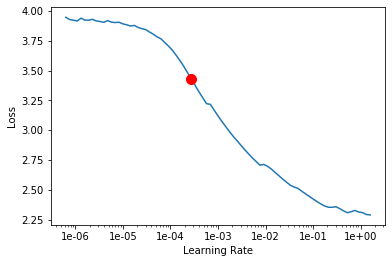

In [14]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [ ]:
#learner.fit_one_cycle(500, max_lr=learner.recorder.min_grad_lr)

In [ ]:
#learner.save(MODEL_NAME)

## Test on our Data

In [13]:
x, y, _ = databunch.valid_dl.tensors
x_device = x.to(device=DEVICE)
y_pred = model(x_device).detach().cpu().numpy()

RuntimeError: CUDA out of memory. Tried to allocate 384.00 MiB (GPU 0; 31.72 GiB total capacity; 30.43 GiB already allocated; 294.31 MiB free; 30.44 GiB reserved in total by PyTorch)

## Test on Bonito Data

In [120]:
bonito_data_path = "../../../bonito/bonito/data"
#data = bonito.util.load_data(directory=bonito_data_path)
chunks, chunk_lengths, targets, target_lengths = bonito.util.load_data(limit=1, directory=bonito_data_path)

In [121]:
chunks.dtype, chunk_lengths.dtype, targets.dtype, target_lengths.dtype

(dtype('float32'), dtype('uint16'), dtype('uint8'), dtype('uint16'))

In [125]:
chunks.mean()

-0.0065521644

In [79]:
chunks, chunk_lengths, targets, target_lengths = map(np.array, (chunks, chunk_lengths, targets, target_lengths))

In [80]:
testdata = bonito.training.ChunkDataSet(chunks, chunk_lengths, targets, target_lengths)
dataloader = DataLoader(testdata, batch_size=BS)

In [176]:
results = []
with torch.no_grad():
    for batch_idx, (data, out_lengths, target, lengths) in enumerate(dataloader, start=1):
        
        data, target = data.to(DEVICE), target.to(DEVICE)
        log_probs = model(data).detach().cpu().numpy()
        
        results += (batch_idx, data, out_lengths, target, lengths, log_probs)       

In [177]:
batch_idx, data, out_lengths, target, lengths, log_probs = results

In [178]:
data.shape, out_lengths, target.shape, lengths, log_probs.shape

(torch.Size([1, 1, 4800]),
 tensor([3636], dtype=torch.int32),
 torch.Size([1, 400]),
 tensor([381], dtype=torch.int32),
 (1, 1600, 5))

In [179]:
actual = pop.convert_idx_to_base_sequence(target[0], ALPHABET_VAL)

In [185]:
prediction = log_probs; prediction

array([[[-0.062224, -5.97276 , -3.035085, -4.946698, -5.951125],
        [-0.102751, -2.736266, -3.465993, -6.86299 , -7.507209],
        [-5.453623, -0.055677, -6.383053, -3.077139, -6.168561],
        [-0.783411, -1.047214, -9.657618, -1.649778, -9.381308],
        ...,
        [-0.283705, -3.178688, -2.230607, -2.763137, -3.357722],
        [-0.806489, -1.805606, -1.309533, -2.429527, -3.468034],
        [-1.087876, -1.382959, -1.275261, -2.255162, -3.574876],
        [-0.760871, -1.140428, -1.86716 , -3.175094, -4.091978]]], dtype=float32)

In [186]:
prediction.shape

(1, 1600, 5)

In [163]:
pred_maxed = prediction.argmax(dim=2)
pred_maxed.shape
pred_maxed_list = list(pred_maxed.view((1600,)))
pred_maxed_list_int = list(map(int, pred_maxed_list))

In [167]:
predicted_str = "".join([ALPHABET[x] for x in pred_maxed_list_int])

In [171]:
pred_clean = pop.__remove_duplicates_and_blanks(predicted_str); pred_clean

'AGAGATGTGATTTCTTTTGGTAGTCATCTGTCGTCTTGAGGCGTATAAGAAGGAGGTTATATCTGTCCTTCTCAAAAGTATTTTCGAGAATCTTACTTCTGCCCCTTTTTTCTTTTTTAAGGATTTTAAAAAGCATAACTGTCTTCAATATATCCAGTATTTACGACAATAGCAAACATAATCATGTCCAAGAGCAAAACTTTCTTATTTACCTCTGAATCGTCGGTGAAGGTCACCCAGACAAGATTTGTGACCAAGTTTCTGTGCTATTTTGGACGCTTGTTTAGAACGAATCCATTCTCCAAGGTTGCCTGTGAAACAGCTGCCAAAACTGGTATGATTGCATGGTTTCGGTGAATTACCACAGTGGCGCGGGTGCGGCTGGTTTGGCGGC'

In [153]:
actual

'AGGAGATCTTGATTTCTTTTTGGTAGTCATCTGTCGTCTTGAGGCGTATAAGAAGGAGGTTATATCTGTCCTTTCTACAAAGTATTTTCGAGAATCTTGCTTCTGCCCCTTTTTTCTTTTTTTAAAAGGTTTAAAAAACATAACTGTCTTCAATATATCCAGTATTTACGACAATATACAAACATAATCATGTCCAAGAGCAAAACTTTCTTATTTACCTCTGAATCCGTCGGTGAAGGTCACCCAGACAAGATTTGTGACCAAGTTTCTGATGCTATTTTGGACGCTTGTTTAGAACAAGATCCATTCTCCAAGGTTGCCTGTGAAACAGCTGCCAAAACTGGTATGATTATGGTTTTCGGTGAAATTACCACCAAAGCT'

In [174]:
pop.calc_sequence_error_metrics(actual, pred_clean)

0.005249343832021025

In [175]:
len(pred_clean), len(actual)

(394, 381)

In [187]:
r = range(min(5, DIMENSIONS_PREDICTION_OUT), min(DIMENSIONS_PREDICTION_OUT+1, 50))
for pred, beam, error in e.get_stats(prediction[0], actual, ALPHABET_STR, r):
    print(pred, beam, error.error)

AGGAGATCTTGATTTCTTTTTGGTAGTCATCTGTCGTCTTGAGGCGTATAAGAAGGAGGTTATATCTGTCCTTTCTACAAAGTATTTTCGAGAATCTTGCTTCTGCCCCTTTTTTCTTTTTTTAAAAGGTTTAAAAAACATAACTGTCTTCAATATATCCAGTATTTACGACAATATACAAACATAATCATGTCCAAGAGCAAAACTTTCTTATTTACCTCTGAATCCGTCGGTGAAGGTCACCCAGACAAGATTTGTGACCAAGTTTCTGATGCTATTTTGGACGCTTGTTTAGAACAAGATCCATTCTCCAAGGTTGCCTGTGAAACAGCTGCCAAAACTGGTATGATTATGGTTTTCGGTGAAATTACCACCAAAGCT
AGAGATGTGATTTCTTTTGGTAGTCATCTGTCGTCTTGAGGCGTATAAGAAGGAGGTTATATCTGTCCTTCTCTAAAAGTATTTTCGAGAATCTTCTTCTGCCCCTTTTTTCTTTTTTAAGGATTTTAAAAAGCATAACTGTCTTCAATATATCCAGTATTTACGACAATAGCAAACATAATCATGTCCAAGAGCAAAACTTTCTTATTTACCTCTGAATCCGTCGGTGAAGGTCACCCAGACAAGATTTGTGACCAAGTTTCTGTGCTATTTTGGACGCTTGTTTAGAACGAATCCATTCTCCAAGGTTGCCTGTGGAAACAGCTGCCAAAACTGGTATGATTGCTGGTTTCGGTGAATTACCCAGCTGGCGCCCGCGGGTGCGGGCGCTGGTTTGAGCGGGGCA 5 0.994750656167979
AGAGATGTGATTTCTTTTGGTAGTCATCTGTCGTCTTGAGGCGTATAAGAAGGAGGTTATATCTGTCCTTCTCAAAAGTATTTTCGAGAATCTTCTTCTGCCCCTTTTTTCTTTTTTAAGGATTTTAAAAAGCATAACTGTCTTCAATATATCCAGTATTTACGACAATAGCAAACATAATCATGTCCAAG

In [14]:
r = range(min(5, DIMENSIONS_PREDICTION_OUT), min(DIMENSIONS_PREDICTION_OUT+1, 50)) #Range can't contain values larger than PRED_OUT_DIM

for index in [0, BS-1]:
    actual = pop.convert_idx_to_base_sequence(y[index], ALPHABET_VAL)
    prediction = y_pred[index]
    for pred, beam, error in e.get_stats(prediction, actual, ALPHABET_STR, r):
        print(pred, beam, error.error)
    print('')

CGACATCGAGGTGCCAAACCTCC
GGCTGTCGAGTGCCGCAGAGCATA 5 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 6 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 7 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 8 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 9 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 10 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 11 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 12 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 13 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 14 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 15 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 16 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 17 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 18 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 19 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 20 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 21 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 22 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 23 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 24 0.6956521739130435
GGCTGTCGAGTGCCGCAGAGCATA 25 0.69565217391

In [15]:
# Run assemble only if data is not fetched from featherfile
# TODO: Assembled should not be on a batch, but instead on a complete signal
if STRIDE-1 != WINDOW_SIZE:
    decoded = pop.decode(y_pred, ALPHABET_STR, beam_size=15)
    assembled = pop.assemble(decoded, WINDOW_SIZE, STRIDE, ALPHABET)
    print('Assembled:', assembled)

Assembled: G-G-GGGGC-GACAGGGGCGCAGGCCGCGCG--C-CC--GG-CAC-G-GGG---
